# TorchVision Object Detection Finetuning Tutorial

Based on the tutorial: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [13]:
NAME = 'torchvision_tutorial'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_PATH = 'data/penn_fudan'

In [14]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [15]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

### Defining the Datase

In [16]:
import typing
from datasets.penn_fudan_data import PennFudanData

data = PennFudanData(root_path=DATA_PATH)
datasets = data.datasets

print(
    "Loading PennFudanData",
    len(datasets.train) if isinstance(datasets.train, typing.Sized) else None,
    len(datasets.validation or []) if isinstance(datasets.validation, typing.Sized) else None,
    len(datasets.test or []) if isinstance(datasets.test, typing.Sized) else None)

Loading PennFudanData 120 25 25


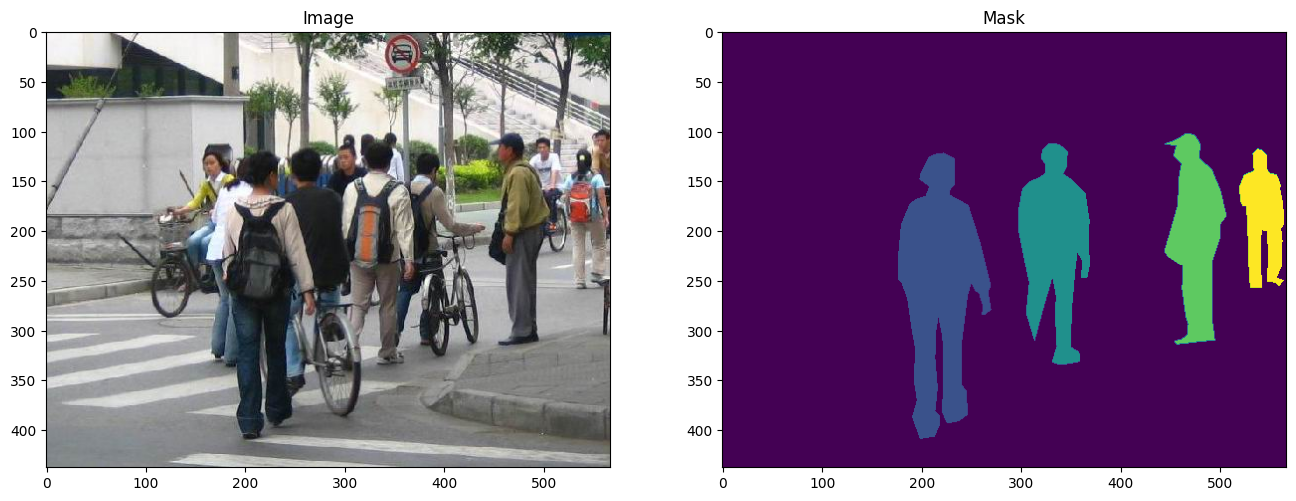

In [17]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image(f"{data.main_data_dir}/PNGImages/FudanPed00046.png")
mask = read_image(f"{data.main_data_dir}/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

### Defining your model

**1 - Finetuning from a pretrained model**

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

**2 - Modifying the model to add a different backbone**

In [19]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280 # type: ignore

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

**Object detection and instance segmentation model for PennFudan Dataset**

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

**Putting everything together**

In [21]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

**Testing forward() method (Optional)**

In [22]:
import torch
from torchvision_tutorial import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = datasets.train
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.2000, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0517, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0265, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0047, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


### Creating Dataloaders, Model and Optimizer

In [23]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

datasets = data.datasets.transform(lambda data: (data, 0)).sized()

def collate_fn(batch):
    result = tuple(zip(*batch))
    return result

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
    datasets.train,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
)

validation_dataloader = torch.utils.data.DataLoader(
    datasets.validation,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    datasets.test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

### Creating the manager

In [24]:
import typing
import math
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from synth_mind import supervised
from synth_mind.supervised.handlers import Evaluator, BatchAccuracyCalculator, BatchAccuracyParams, BatchExecutor, BatchExecutorParams
from lib.metrics import (
    MetricsListPlotter, MainMetrics, DatasetsAmountsMetrics, MetricsFileDirectPlotter)

class MyBatchExecutor(BatchExecutor[typing.Any, typing.Any]):
    def run(self, params: BatchExecutorParams[typing.Any, typing.Any]) -> typing.Any:
        images = list(image.to(device) for image, _ in params.input)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for _, t in params.input]
        loss_dict = model(images, targets)
        return loss_dict

    def main_output(self, output: typing.Any) -> typing.Any:
        return output

class MyLoss(torch.nn.Module):
    def forward(self, output: typing.Any, target: typing.Any):
        if not isinstance(output, dict):
            if torch.is_grad_enabled():
                raise ValueError("output must be a dict")

            return torch.tensor(0.0)

        losses = sum(loss for loss in output.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(output)
        losses_reduced: typing.Any = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        return losses

class MyEvaluator(Evaluator[typing.Any, torch.Tensor]):
    def run(self, params):
        with torch.no_grad():
            image = params.input
            model = params.model

            eval_transform = data.get_transform(train=False)
            x = eval_transform(image)
            # convert RGBA -> RGB and move to device
            x = x[:3, ...].to(device)

            model.eval()
            predictions = model([x, ])
            pred = predictions[0]

            image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
            image = image[:3, ...]
            pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
            pred_boxes = pred["boxes"].long()
            output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

            masks = (pred["masks"] > 0.7).squeeze(1)
            output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

            return output_image

class MyAccuracyCalculator(BatchAccuracyCalculator):
    def run(self, params: BatchAccuracyParams) -> float:
        return 0.5

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        test_dataloader=test_dataloader,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=MyLoss(),
        executor=MyBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optimizer,
        scheduler=lr_scheduler,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MyEvaluator(),
        accuracy_calculator=MyAccuracyCalculator(),
        metrics_calculator=MetricsFileDirectPlotter(
            plotter=MetricsListPlotter(items=[
                MainMetrics(name=NAME, no_accuracy=True),
                DatasetsAmountsMetrics(name=f"{NAME}_records", datasets=datasets),
            ]),
            file_path=REPORT_PATH,
            figsize=(8, 8),
        ),
        batch_interval=True,
        save_every=10,
        print_every=10,
        metric_every=10,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

### Training and Metrics

Training already completed (2 epochs).
Test already completed (test epoch: 2, last trained epoch: 2).


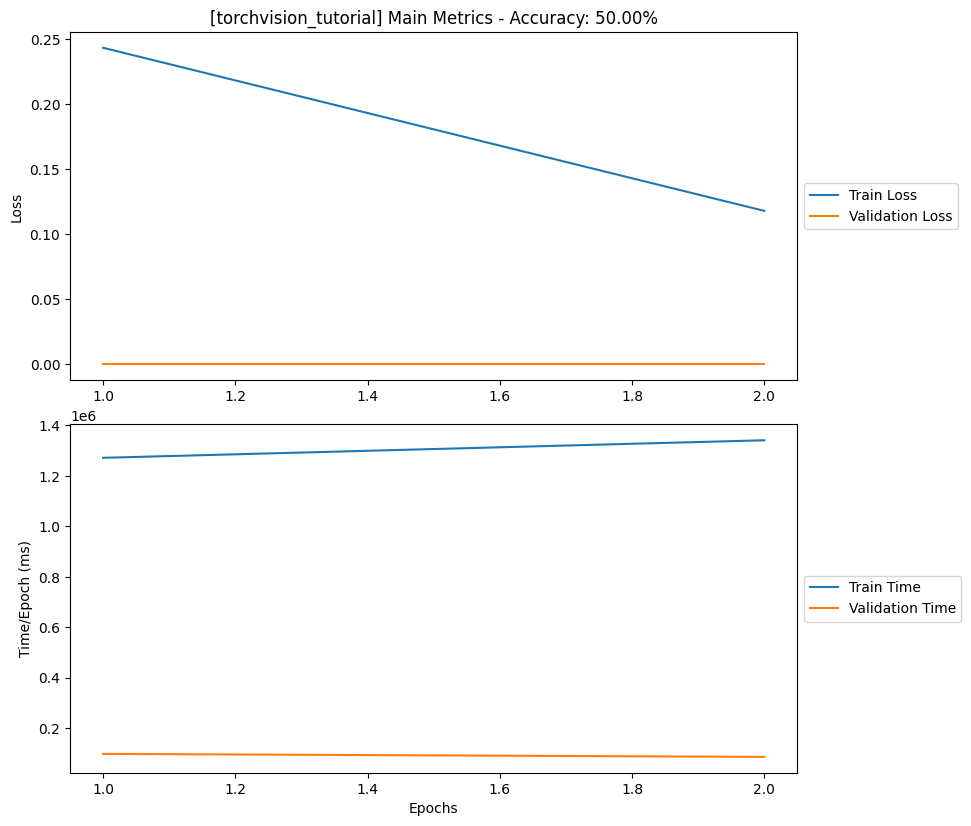

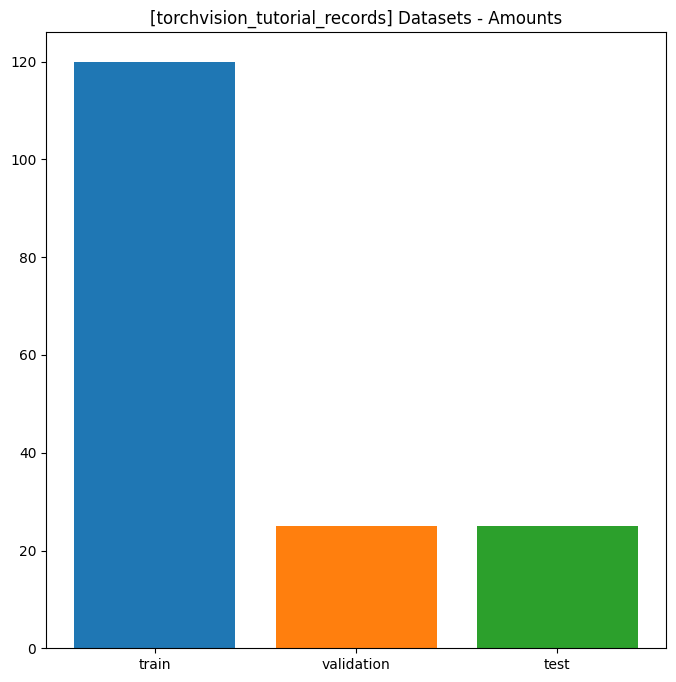

In [25]:
manager.train(epochs=2)

### Making Predictions

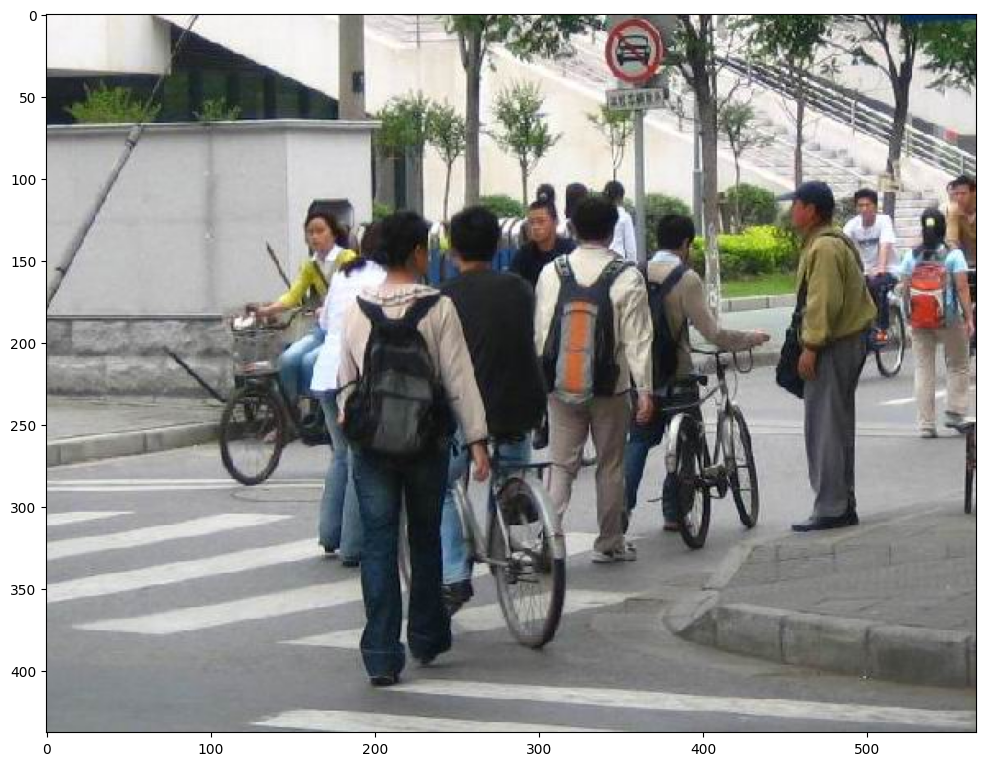

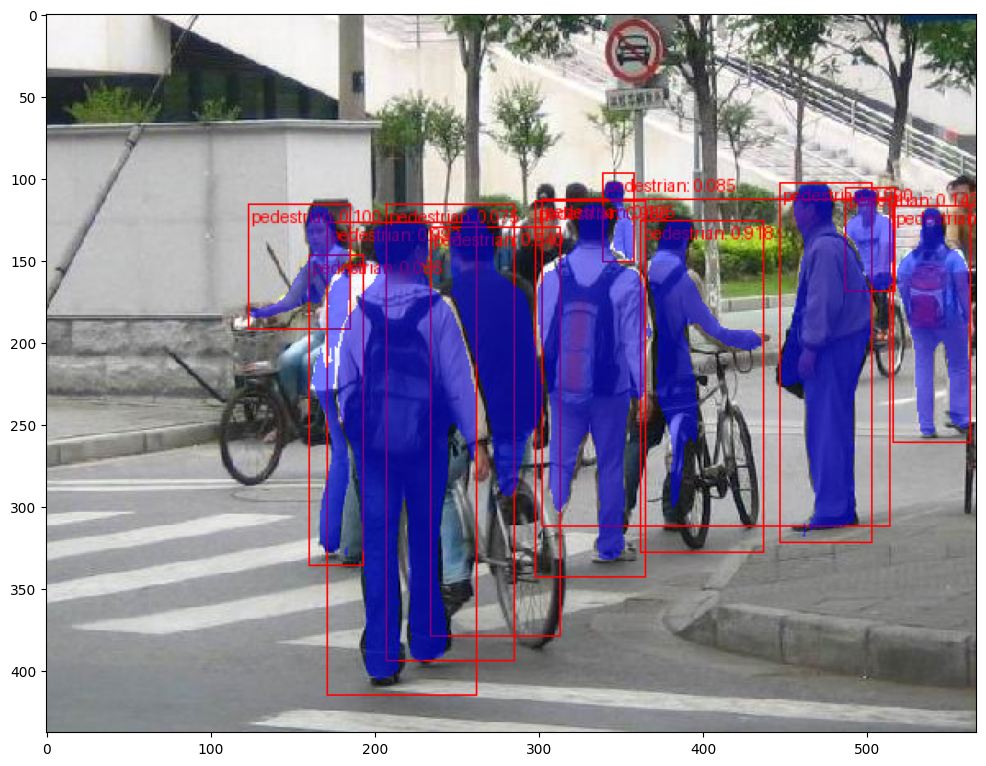

In [26]:
import matplotlib.pyplot as plt

image = read_image(f"{data.main_data_dir}/PNGImages/FudanPed00046.png")

output_image = manager.evaluate(image)

plt.figure(figsize=(12, 12))
plt.imshow(image.permute(1, 2, 0))

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))